# Demonstrate GP Regression through a toy example
Notebook for: https://zoekko.github.io/blog/gps/gp-toy-example.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import jax
import jax.numpy as jnp
from scipy.stats import norm, multivariate_normal
from tinygp import GaussianProcess, kernels

jax.config.update("jax_enable_x64", True)

In [2]:
# For plots
import matplotlib as mpl

# Plot resolution
dpi = 150

# Set the default font
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['URW Gothic']

Make up some fake data: for example, a noisy sine wave as temperature over time.

In [3]:
# Seed for reproducibility
rng = np.random.default_rng(42)

X_obs = np.array([7, 50, 230, 270, 360])

amplitude = 25
vertical_shift = 65
period = 365

def true_func(x):
    # One full sine cycle over 365 days
    return amplitude * np.sin(2 * np.pi * (x - 1) / period) + vertical_shift

# Add noise
y_obs = true_func(X_obs) + rng.normal(scale=4, size=X_obs.shape)

Plot the observed data.

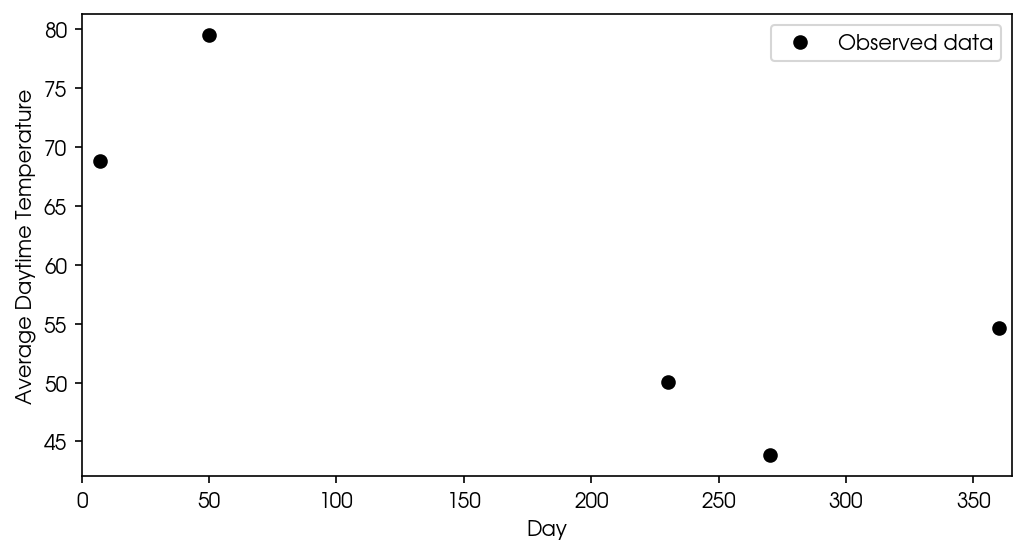

In [4]:
plt.figure(figsize=(8, 4), dpi=dpi)
plt.plot(X_obs, y_obs, 'o', color='black', label="Observed data")
# plt.scatter(X_obs, true_func(X_obs))
plt.xlabel("Day")
plt.ylabel("Average Daytime Temperature")
plt.xlim(0, 365)
plt.legend()
plt.show()

GP setup with tinygp. I use the squared exponential kernel ("ExpSquared"), a popular kernel for smooth data. 

The GP kernel has two hyperparameters: amplitude and length scale, which control how flexible the fitted function is and how much it can wiggle to fit the data. 
* Amplitude: Controls the overall vertical scale/variability. A larger amplitude means the GP expects bigger changes in y.
* Length scale: Controls how quickly the function can vary. Small length scales mean the GP can make tight wiggles, fitting sharp changes, while large length scales mean smoother, slower-changing functions.

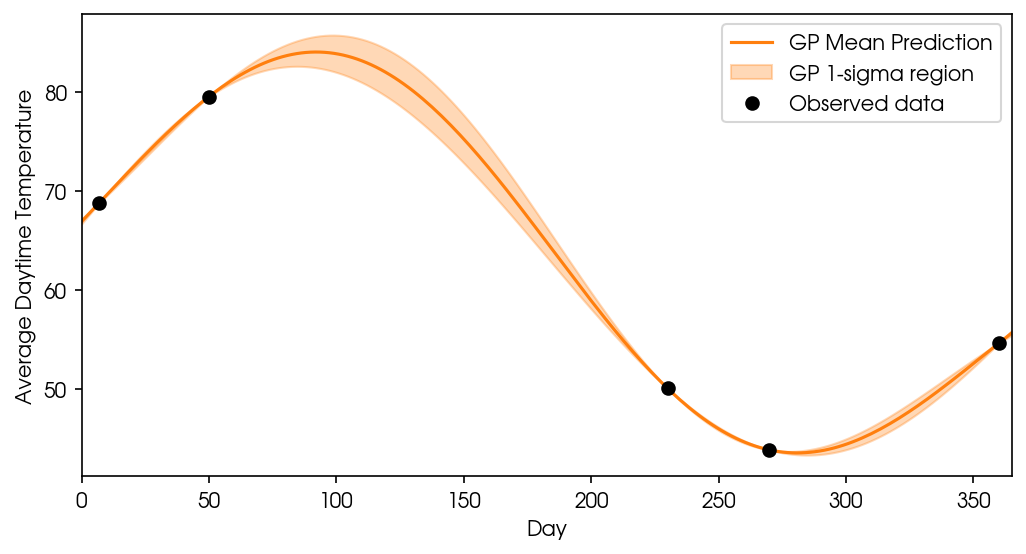

In [5]:
from tinygp import kernels, GaussianProcess

# Set the mean
mean_temp = np.mean(y_obs)

# Set amplitude and length scale
kernel = 150 * kernels.ExpSquared(scale=100)

# No measurement error
gp = GaussianProcess(kernel, X_obs, mean = mean_temp)

# The test inputs for prediction
X_test = np.linspace(0, 365, 200)

# Condition the GP
_, cond_gp = gp.condition(y_obs, X_test)

mu = np.array(cond_gp.mean)         # predicted mean
std = np.sqrt(np.array(cond_gp.variance))    # standard deviation

plt.figure(figsize=(8, 4), dpi=dpi)
plt.plot(X_test, mu, "C1", label="GP Mean Prediction")
plt.fill_between(X_test, mu-std, mu+std, color="C1", alpha=0.3, label="GP 1-sigma region")
plt.plot(X_obs, y_obs, "ok", label="Observed data")
plt.xlabel("Day")
plt.ylabel("Average Daytime Temperature")
plt.xlim(0, 365)
plt.legend()
plt.show()

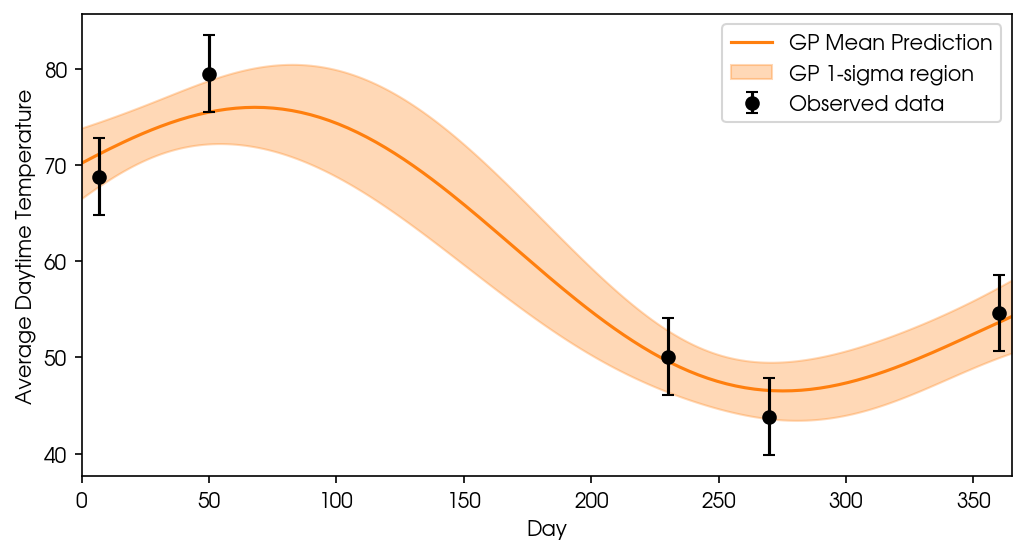

In [6]:
# This time, include measurement error
gp = GaussianProcess(kernel, X_obs, diag=4.0**2, mean=mean_temp)

# The test inputs for prediction
X_test = np.linspace(0, 365, 200)

# Condition the GP
_, cond_gp = gp.condition(y_obs, X_test)

mu = np.array(cond_gp.mean)         # predicted mean
std = np.sqrt(np.array(cond_gp.variance))    # standard deviation

plt.figure(figsize=(8, 4), dpi=dpi)
plt.plot(X_test, mu, "C1", label="GP Mean Prediction")
plt.fill_between(X_test, mu-std, mu+std, color="C1", alpha=0.3, label="GP 1-sigma region")
plt.errorbar(X_obs, y_obs, yerr=4.0, fmt="ok", capsize=3, label="Observed data")
plt.xlabel("Day")
plt.ylabel("Average Daytime Temperature")
plt.xlim(0, 365)
plt.legend()
plt.show()


Take a slice through day 6 to visualize the 1-D Gaussian there.

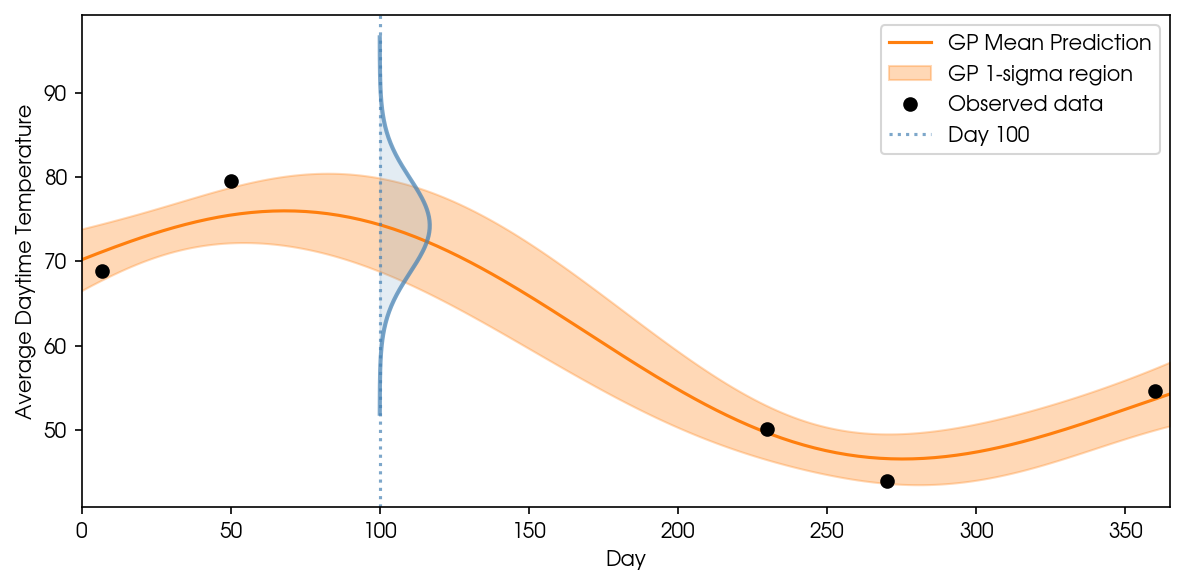

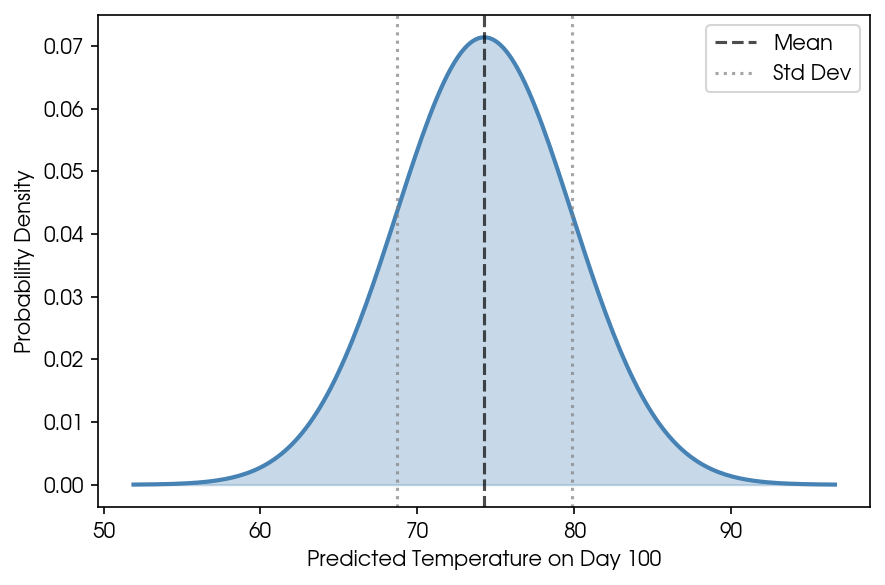

In [7]:
day = 100
idx = np.argmin(np.abs(X_test - day))
mu_100 = mu[idx]
std_100 = std[idx]

gauss_y = np.linspace(mu_100 - 4*std_100, mu_100 + 4*std_100, 200)
gauss_x = norm.pdf(gauss_y, loc=mu_100, scale=std_100)
scaling = 3 * std_100 / np.max(gauss_x)

plt.figure(figsize=(8, 4), dpi=dpi)
plt.plot(X_test, mu, "C1", label="GP Mean Prediction")
plt.fill_between(X_test, mu-std, mu+std, color="C1", alpha=0.3, label="GP 1-sigma region")
plt.plot(X_obs, y_obs, "ok", label="Observed data")
plt.axvline(day, color="steelblue", ls=":", alpha=0.7, label="Day 100")

plt.plot(day + gauss_x * scaling, gauss_y, color="steelblue", lw=2, alpha=0.7)
plt.fill_betweenx(gauss_y, day, day + gauss_x * scaling, color="steelblue", alpha=0.15)

plt.xlabel("Day")
plt.ylabel("Average Daytime Temperature")
plt.xlim(0, 365)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4), dpi=dpi)
plt.plot(gauss_y, gauss_x, color="steelblue", lw=2)
plt.fill_between(gauss_y, gauss_x, color="steelblue", alpha=0.3)
plt.axvline(mu_100, color="k", ls="--", alpha=0.7, label="Mean")
plt.axvline(mu_100 + std_100, color="gray", ls=":", alpha=0.7, label="Std Dev")
plt.axvline(mu_100 - std_100, color="gray", ls=":", alpha=0.7)
plt.xlabel("Predicted Temperature on Day 100")
plt.ylabel("Probability Density")
plt.legend()
plt.tight_layout()
plt.show()

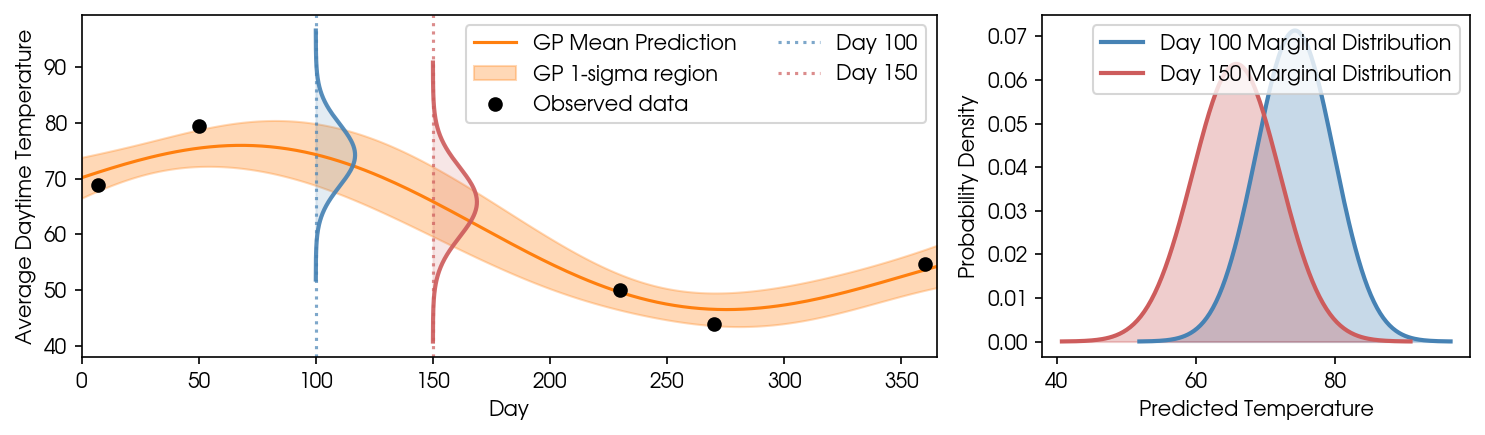

In [8]:
days = [100, 150]
colors = ["steelblue", "indianred"]

gauss_curves = []
mus = []
stds = []
gauss_ys = []
scalings = []

# Calculate mean, std, marginal pdf for each day
for day in days:
    idx = np.argmin(np.abs(X_test - day))
    mu_day = mu[idx]
    std_day = std[idx]
    mus.append(mu_day)
    stds.append(std_day)
    gauss_y = np.linspace(mu_day - 4*std_day, mu_day + 4*std_day, 200)
    gauss_x = norm.pdf(gauss_y, loc=mu_day, scale=std_day)
    scaling = 3 * std_day / np.max(gauss_x)
    gauss_ys.append(gauss_y)
    scalings.append(scaling)
    gauss_curves.append((day, gauss_y, gauss_x, scaling, mu_day, std_day))

fig, axarr = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios':[2,1]}, dpi=dpi)

ax = axarr[0]
ax.plot(X_test, mu, "C1", label="GP Mean Prediction")
ax.fill_between(X_test, mu-std, mu+std, color="C1", alpha=0.3, label="GP 1-sigma region")
ax.plot(X_obs, y_obs, "ok", label="Observed data")

for i, (day, gauss_y, gauss_x, scaling, mu_day, std_day) in enumerate(gauss_curves):
    color = colors[i]
    ax.axvline(day, color=color, ls=":", alpha=0.7, label=f"Day {day}")
    ax.plot(day + gauss_x * scaling, gauss_y, color=color, lw=2, alpha=0.9)
    ax.fill_betweenx(gauss_y, day, day + gauss_x * scaling, color=color, alpha=0.15)

ax.set_xlabel("Day")
ax.set_ylabel("Average Daytime Temperature")
ax.set_xlim(0, 365)
ax.legend(ncol=2)

ax = axarr[1]
for i, (day, gauss_y, gauss_x, scaling, mu_day, std_day) in enumerate(gauss_curves):
    color = colors[i]
    ax.plot(gauss_y, gauss_x, color=color, lw=2, label=f"Day {day} Marginal Distribution")
    ax.fill_between(gauss_y, gauss_x, color=color, alpha=0.3)
    # ax.axvline(mu_day, color="k", ls="--", alpha=0.7)

ax.set_xlabel("Predicted Temperature")
ax.set_ylabel("Probability Density")
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

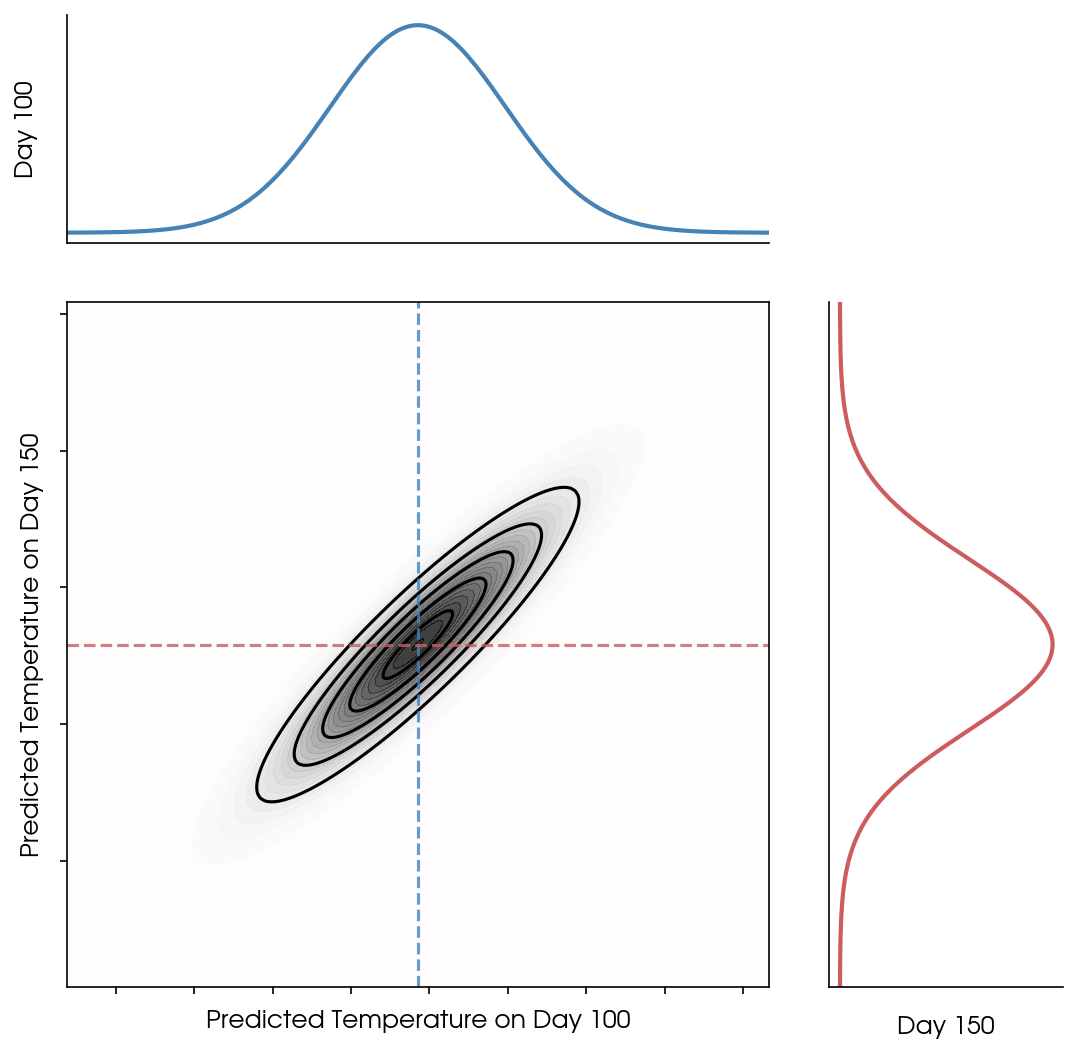

In [9]:
idxs = [np.argmin(np.abs(X_test - d)) for d in days]
mus = [mu[idx] for idx in idxs]
stds = [std[idx] for idx in idxs]
cov_mat = np.array(cond_gp.covariance)[np.ix_(idxs, idxs)]

pad1 = 4 * stds[0]
pad2 = 4 * stds[1]
x = np.linspace(mus[0] - pad1, mus[0] + pad1, 200)
y = np.linspace(mus[1] - pad2, mus[1] + pad2, 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

rv = multivariate_normal(mean=mus, cov=cov_mat)
Z = rv.pdf(pos)

marg1 = norm.pdf(x, loc=mus[0], scale=stds[0])
marg2 = norm.pdf(y, loc=mus[1], scale=stds[1])

fig = plt.figure(figsize=(8,8), dpi=dpi)
gs = plt.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[1,3], hspace=0.13, wspace=0.13)

# Marginal for day 100
ax_histx = fig.add_subplot(gs[0,0])
ax_histx.plot(x, marg1, color="steelblue", lw=2)
ax_histx.set_xlim(x[0], x[-1])
ax_histx.set_xticklabels([])
ax_histx.set_yticklabels([])
ax_histx.tick_params(axis='x', which='both', bottom=False, top=False)
ax_histx.tick_params(axis='y', which='both', left=False, right=False)
ax_histx.set_ylabel("Day 100", fontsize=12, labelpad=7)

# Marginal for day 150
ax_histy = fig.add_subplot(gs[1,1])
ax_histy.plot(marg2, y, color="indianred", lw=2)
ax_histy.set_ylim(y[0], y[-1])
ax_histy.set_xticklabels([])
ax_histy.set_yticklabels([])
ax_histy.tick_params(axis='x', which='both', bottom=False, top=False)
ax_histy.tick_params(axis='y', which='both', left=False, right=False)
ax_histy.set_xlabel("Day 150", fontsize=12, labelpad=7)

# Joint Contour
ax_joint = fig.add_subplot(gs[1,0])
cf = ax_joint.contourf(X, Y, Z, levels=30, cmap="Greys", alpha=0.8)
c = ax_joint.contour(X, Y, Z, colors='k', linewidths=1.5, levels=6)
ax_joint.set_xlim(x[0], x[-1])
ax_joint.set_ylim(y[0], y[-1])
ax_joint.set_xlabel("Predicted Temperature on Day 100", fontsize=12)
ax_joint.set_ylabel("Predicted Temperature on Day 150", fontsize=12)
ax_joint.axvline(mus[0], color='steelblue', ls='--', lw=1.5, alpha=0.8)
ax_joint.axhline(mus[1], color='indianred', ls='--', lw=1.5, alpha=0.8)
ax_joint.set_xticklabels([])
ax_joint.set_yticklabels([])

ax_histx.tick_params(left=False)
ax_histy.tick_params(bottom=False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['right'].set_visible(False)

plt.subplots_adjust(left=0.11, right=0.94, top=0.92, bottom=0.11, hspace=0.13, wspace=0.13)
plt.show()

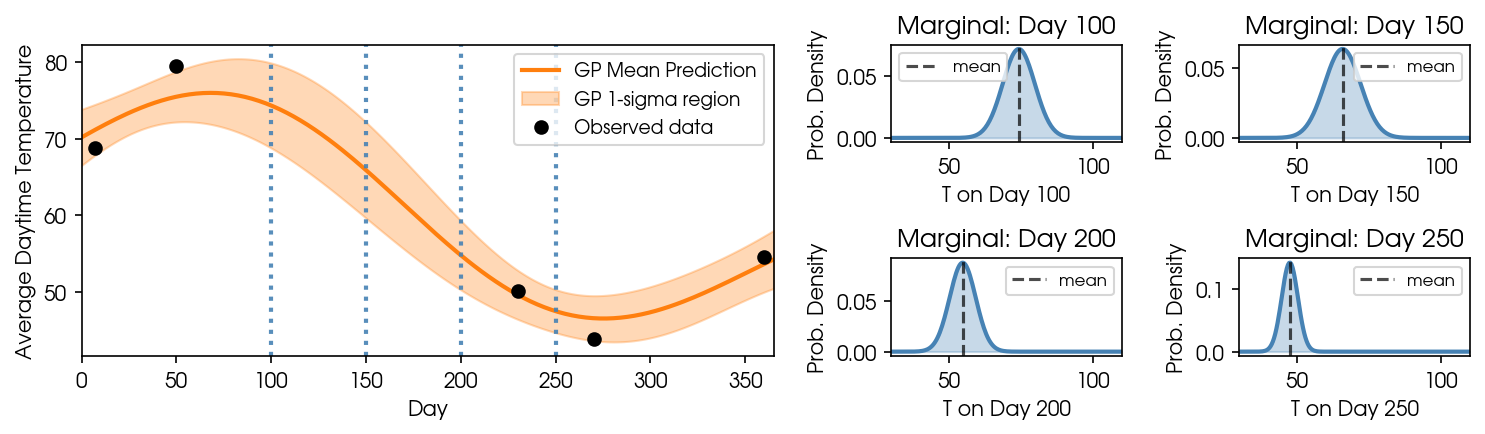

In [10]:
slice_days = [100, 150, 200, 250]

idxs = [np.argmin(np.abs(X_test - d)) for d in slice_days]
slice_mus = [mu[idx] for idx in idxs]
slice_stds = [std[idx] for idx in idxs]

fig = plt.figure(figsize=(10, 3), dpi=dpi)
gs = gridspec.GridSpec(2, 3, width_ratios=[3, 1, 1])

ax_main = fig.add_subplot(gs[:, 0])
ax_main.plot(X_test, mu, color="C1", lw=2, label="GP Mean Prediction")
ax_main.fill_between(X_test, mu-std, mu+std, color="C1", alpha=0.3, label="GP 1-sigma region")
ax_main.plot(X_obs, y_obs, "ok", label="Observed data")
for day in slice_days:
    ax_main.axvline(day, color="steelblue", ls=":", alpha=0.9, lw=2)
ax_main.set_xlabel("Day")
ax_main.set_ylabel("Average Daytime Temperature")
ax_main.set_xlim(0, 365)
ax_main.legend(fontsize=9)

for n, (mu_slice, std_slice, day) in enumerate(zip(slice_mus, slice_stds, slice_days)):
    row = n // 2  # 0 or 1
    col = 1 + (n % 2)  # 1 or 2
    ax = fig.add_subplot(gs[row, col])
    gauss_x = np.linspace(30, 110, 200)
    gauss_y = norm.pdf(gauss_x, loc=mu_slice, scale=std_slice)
    ax.plot(gauss_x, gauss_y, color="steelblue", lw=2)
    ax.fill_between(gauss_x, gauss_y, color="steelblue", alpha=0.3)
    ax.axvline(mu_slice, color="k", ls="--", alpha=0.7, label="mean")
    ax.set_xlim(30, 110)
    ax.set_xlabel(f"T on Day {day}")
    ax.set_ylabel("Prob. Density")
    ax.set_title(f"Marginal: Day {day}")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

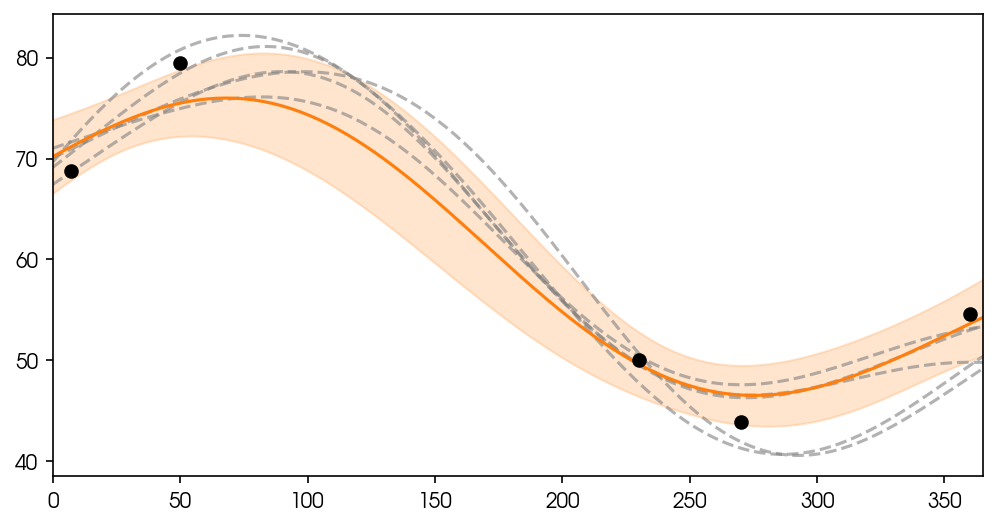

In [11]:
plt.figure(figsize=(8, 4), dpi=dpi)

y_samples = cond_gp.sample(jax.random.PRNGKey(123), shape=(5,))
for i in range(y_samples.shape[0]):
    plt.plot(X_test, y_samples[i], "--", color="gray", alpha=0.6)
plt.plot(X_test, mu, "C1", label="GP Mean")
plt.fill_between(X_test, mu-std, mu+std, color="C1", alpha=0.2)
plt.plot(X_obs, y_obs, 'ok')
plt.xlim(0, 365)
plt.show()

And that's how GPs can be used for regression!

## Explore different GP kernels

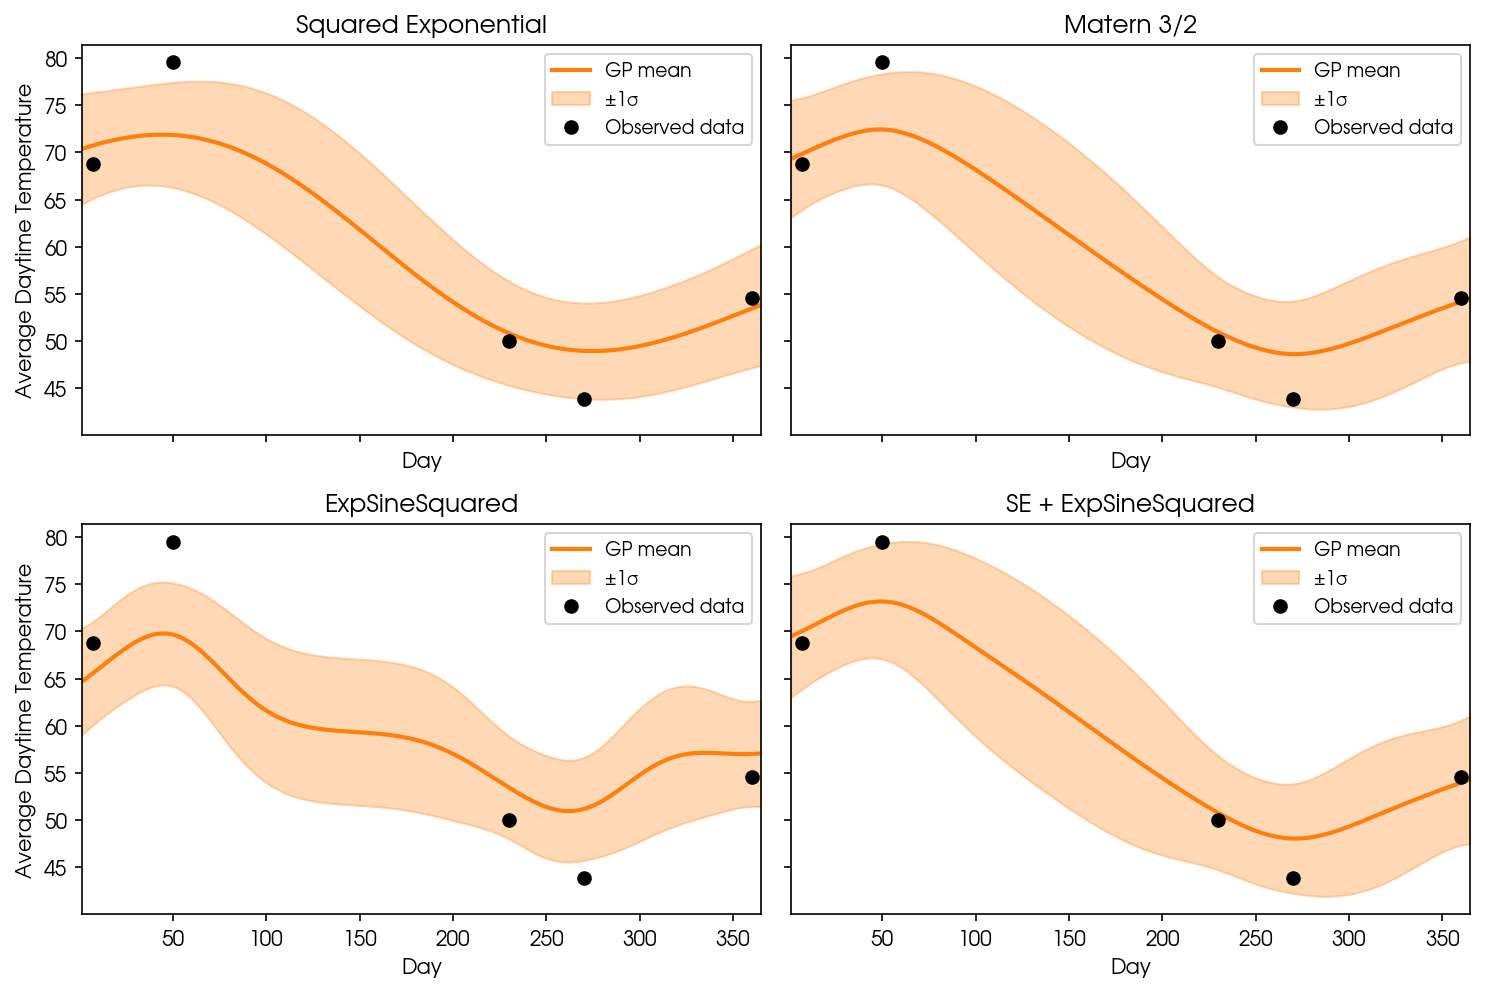

In [12]:
# Test grid for predictions
X_test = np.linspace(1, 365, 200)

kernels_list = [
    ("Squared Exponential", 150 * kernels.ExpSquared(scale=100.0)),
    ("Matern 3/2", 150 * kernels.Matern32(scale=100)),
    ("ExpSineSquared", 60 * kernels.ExpSineSquared(scale=500, gamma=15)),
]
composite_kernel = ("SE + ExpSineSquared",
    150 * kernels.ExpSquared(scale=100) +
    30 * kernels.ExpSineSquared(scale=500, gamma=15)  # 180 is half-year periodicity
)

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True, dpi=dpi)
axes = axes.flatten()

# Plot the three single kernels
for idx, (kern_name, kernel) in enumerate(kernels_list):
    gp = GaussianProcess(kernel, X_obs, diag=8.0**2, mean=mean_temp)  # use realistic noise
    _, cond_gp = gp.condition(y_obs, X_test)
    mu = np.array(cond_gp.mean)
    std = np.sqrt(np.array(cond_gp.variance))

    ax = axes[idx]
    ax.plot(X_test, mu, "C1", lw=2, label="GP mean")
    ax.fill_between(X_test, mu-std, mu+std, color="C1", alpha=0.3, label="±1σ")
    ax.plot(X_obs, y_obs, "ok", label="Observed data")
    ax.set_title(kern_name)
    if idx % 2 == 0: ax.set_ylabel("Average Daytime Temperature")
    ax.set_xlabel("Day")
    ax.set_xlim(1, 365)
    ax.legend(loc='upper right', fontsize=9)

# Plot the composite kernel
gp = GaussianProcess(composite_kernel[1], X_obs, diag=8.0**2, mean=mean_temp)
_, cond_gp = gp.condition(y_obs, X_test)
mu = np.array(cond_gp.mean)
std = np.sqrt(np.array(cond_gp.variance))

ax = axes[3]
ax.plot(X_test, mu, "C1", lw=2, label="GP mean")
ax.fill_between(X_test, mu-std, mu+std, color="C1", alpha=0.3, label="±1σ")
ax.plot(X_obs, y_obs, "ok", label="Observed data")
ax.set_title(composite_kernel[0])
# ax.set_ylabel("Average Daytime Temperature")
ax.set_xlabel("Day")
ax.set_xlim(1, 365)
ax.legend(loc='upper right', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The final fit can look very different depending on GP kernel choice... pick carefully!

## Explore GP hyperparameters: length scale and amplitude

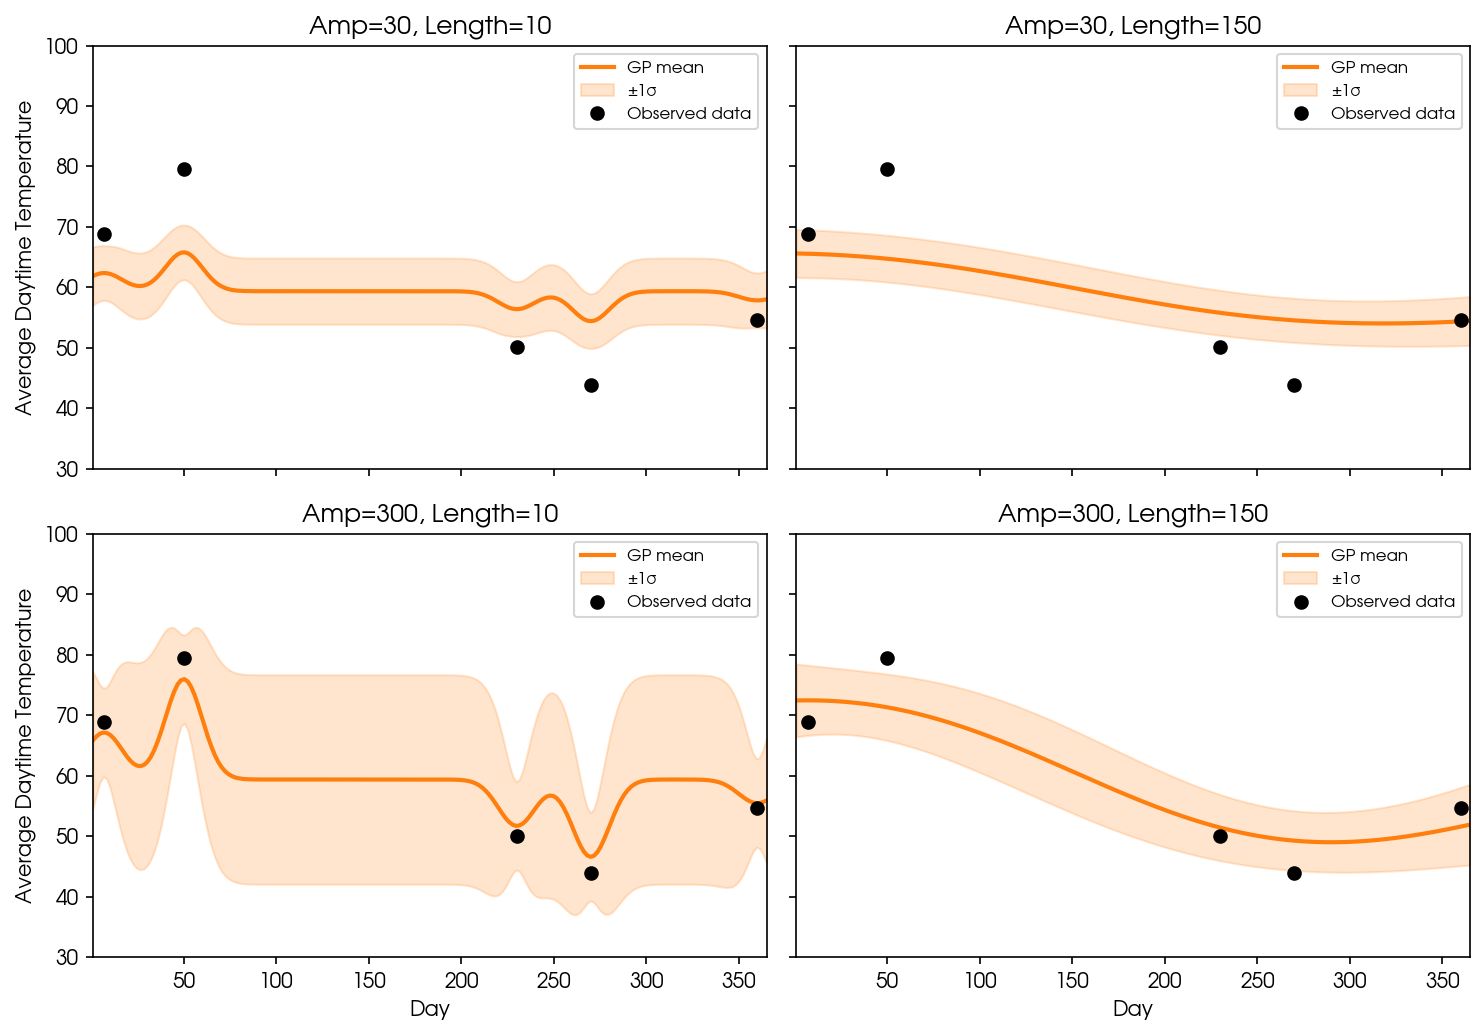

In [13]:
X_test = np.linspace(1, 365, 200)

amplitudes = [30, 300]         # low and high amplitude
length_scales = [10, 150]      # very wiggly and very smooth

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True, dpi=dpi)
axes = axes.flatten()

for i, amp in enumerate(amplitudes):
    for j, ls in enumerate(length_scales):
        idx = i * 2 + j
        kernel = amp * kernels.ExpSquared(scale=ls)
        gp = GaussianProcess(kernel, X_obs, diag=8.0**2, mean=mean_temp)
        _, cond_gp = gp.condition(y_obs, X_test)
        mu = np.array(cond_gp.mean)
        std = np.sqrt(np.array(cond_gp.variance))

        ax = axes[idx]
        ax.plot(X_test, mu, "C1", lw=2, label="GP mean")
        ax.fill_between(X_test, mu-std, mu+std, color="C1", alpha=0.2, label="±1σ")
        ax.plot(X_obs, y_obs, "ok", label="Observed data")
        ax.set_title(f"Amp={amp}, Length={ls}")
        ax.set_xlim(1, 365)
        ax.set_ylim(30, 100)
        if idx >= 2:
            ax.set_xlabel("Day")
        if idx % 2 == 0:
            ax.set_ylabel("Average Daytime Temperature")
        ax.legend(fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()

The final fit can also look very different depending on GP hyperparameter choices... pick carefully! Or better yet, fit for them and determine optimal values.